In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Fix para MKL error en Windows
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Análisis de correlación y discriminación
from scipy.stats import pointbiserialr
from sklearn.feature_selection import mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Reducción de dimensionalidad
from sklearn.decomposition import PCA
from umap import UMAP

# Modelos y métricas (reutilizar mejores de sección 4)
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

def print_section(title):
    display(Markdown(f"### {title}"))
    display(Markdown('---'))

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

c:\Users\Eljac\miniconda3\envs\churn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 5.1 Análisis Individual de Variables

### Objetivo
Identificar características candidatas a ser eliminadas mediante:
- **Correlación entre features:** detectar redundancia (VIF, matriz de correlación)
- **Índice de discriminación:** medir capacidad predictiva individual (mutual information, point-biserial correlation)

### Criterios de eliminación
- VIF > 10: multicolinealidad severa
- Correlación absoluta > 0.9: redundancia alta
- Mutual information < percentil 25: baja capacidad discriminativa

In [2]:
print_section("Carga de Datos (FE - Feature Engineering)")

# Cargar datos con Feature Engineering (mejor estrategia de sección 4)
with open('data/train_data_fe.pkl', 'rb') as f:
    train_fe = pickle.load(f)
with open('data/val_data_fe.pkl', 'rb') as f:
    val_fe = pickle.load(f)
with open('data/test_data_fe.pkl', 'rb') as f:
    test_fe = pickle.load(f)

X_train = train_fe['X']
y_train = train_fe['y']
X_val = val_fe['X']
y_val = val_fe['y']
X_test = test_fe['X']
y_test = test_fe['y']
feature_names = train_fe['columns']

print(f"Train: {X_train.shape[0]} muestras, {X_train.shape[1]} features")
print(f"Val: {X_val.shape[0]} muestras")
print(f"Test: {X_test.shape[0]} muestras")
print(f"\nDistribución de clases (train): {np.bincount(y_train)} -> {(y_train == 1).mean()*100:.2f}% churn")

### Carga de Datos (FE - Feature Engineering)

---

Train: 4800 muestras, 34 features
Val: 1600 muestras
Test: 1600 muestras

Distribución de clases (train): [3557 1243] -> 25.90% churn


### 5.1.1 Matriz de Correlación

### Análisis de Correlación entre Features

---

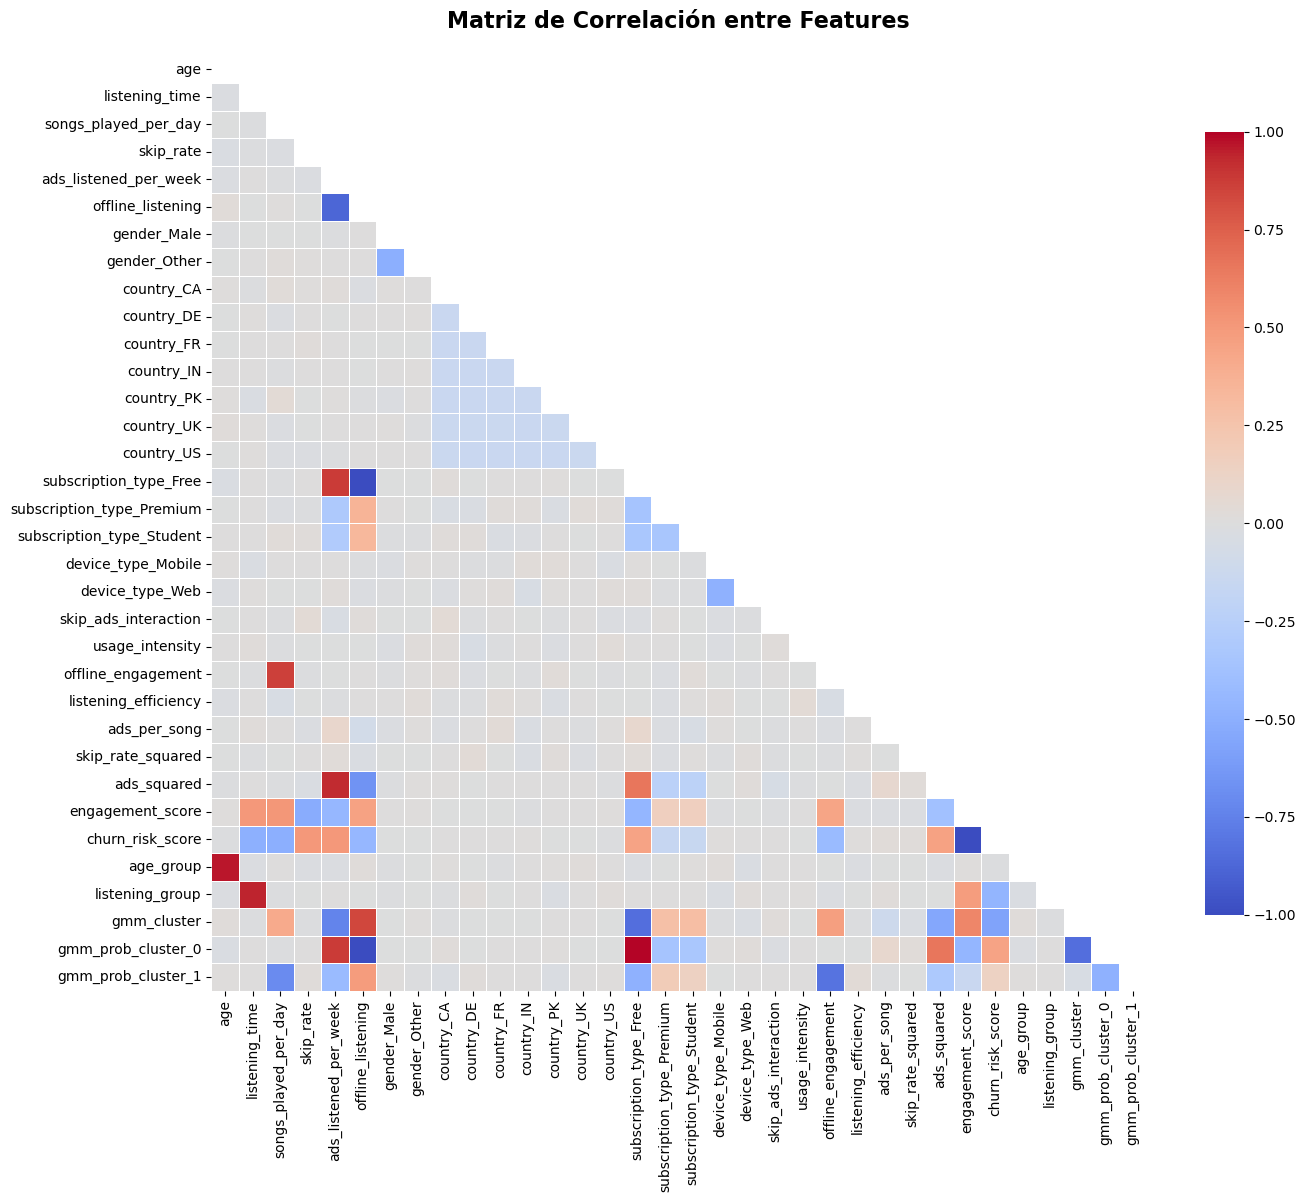


**⚠️ Pares de features con correlación alta (|r| > 0.9):**

,Feature_1,Feature_2,Correlation
0,age,age_group,0.9680
1,listening_time,listening_group,0.9427
2,ads_listened_per_week,ads_squared,0.9243
3,offline_listening,subscription_type_Free,-1.0000
4,offline_listening,gmm_prob_cluster_0,-1.0000
5,subscription_type_Free,gmm_prob_cluster_0,1.0000
6,engagement_score,churn_risk_score,-0.9927


In [3]:
print_section("Análisis de Correlación entre Features")

# Crear DataFrame para análisis
df_train = pd.DataFrame(X_train, columns=feature_names)

# Matriz de correlación
corr_matrix = df_train.corr()

# Visualización
fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, 
            vmin=-1, vmax=1, ax=ax)
ax.set_title('Matriz de Correlación entre Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Identificar pares con correlación alta (>0.9)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append({
                'Feature_1': corr_matrix.columns[i],
                'Feature_2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    display(Markdown("\n**⚠️ Pares de features con correlación alta (|r| > 0.9):**"))
    display(pd.DataFrame(high_corr_pairs).round(4))
else:
    display(Markdown("\n✓ No se encontraron pares con correlación extrema (|r| > 0.9)"))

### 5.1.2 Variance Inflation Factor (VIF)

In [4]:
print_section("Análisis de Multicolinealidad (VIF)")

# Calcular VIF para cada feature
# Nota: VIF puede ser costoso computacionalmente con muchas variables
vif_data = []

display(Markdown("Calculando VIF (puede tardar unos minutos)..."))

for i, col in enumerate(feature_names):
    try:
        vif = variance_inflation_factor(X_train, i)
        vif_data.append({'Feature': col, 'VIF': vif})
    except:
        vif_data.append({'Feature': col, 'VIF': np.nan})

vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False)

display(Markdown("\n**Top 15 features con mayor VIF:**"))
display(vif_df.head(15).round(2))

# Identificar features con VIF > 10 (multicolinealidad severa)
high_vif = vif_df[vif_df['VIF'] > 10]

if not high_vif.empty:
    display(Markdown(f"\n**⚠️ Features con VIF > 10 (multicolinealidad severa): {len(high_vif)}**"))
    display(high_vif.round(2))
else:
    display(Markdown("\n✓ No hay features con VIF > 10 (multicolinealidad aceptable)"))

### Análisis de Multicolinealidad (VIF)

---

Calculando VIF (puede tardar unos minutos)...


**Top 15 features con mayor VIF:**

,Feature,VIF
15,subscription_type_Free,inf
2,songs_played_per_day,inf
3,skip_rate,inf
4,ads_listened_per_week,inf
5,offline_listening,inf
32,gmm_prob_cluster_0,inf
28,churn_risk_score,inf
27,engagement_score,inf
1,listening_time,inf
31,gmm_cluster,49.93



**⚠️ Features con VIF > 10 (multicolinealidad severa): 15**

,Feature,VIF
15,subscription_type_Free,inf
2,songs_played_per_day,inf
3,skip_rate,inf
4,ads_listened_per_week,inf
5,offline_listening,inf
32,gmm_prob_cluster_0,inf
28,churn_risk_score,inf
27,engagement_score,inf
1,listening_time,inf
31,gmm_cluster,49.93


### 5.1.3 Capacidad Discriminativa Individual

### Índices de Discriminación

---


**Top 15 features con mayor capacidad discriminativa:**

,Feature,Mutual_Info,Point_Biserial_Corr,MI_Normalized,PB_Normalized,Avg_Discrimination
9,country_DE,0.0141,0.0100,1.0000,0.0100,0.5050
13,country_UK,0.0076,0.0005,0.5388,0.0005,0.2697
30,listening_group,0.0053,0.0037,0.3729,0.0037,0.1883
14,country_US,0.0042,0.0016,0.2992,0.0016,0.1504
6,gender_Male,0.0029,0.0116,0.2029,0.0116,0.1073
16,subscription_type_Premium,0.0026,0.0082,0.1825,0.0082,0.0953
5,offline_listening,0.0021,0.0023,0.1523,0.0023,0.0773
11,country_IN,0.0016,0.0199,0.1111,0.0199,0.0655
33,gmm_prob_cluster_1,0.0014,0.0256,0.1013,0.0256,0.0635
2,songs_played_per_day,0.0002,0.0308,0.0156,0.0308,0.0232



**Bottom 15 features con menor capacidad discriminativa:**

,Feature,Mutual_Info,Point_Biserial_Corr,MI_Normalized,PB_Normalized,Avg_Discrimination
18,device_type_Mobile,0.0,0.0141,0.0,0.0141,0.0070
29,age_group,0.0,0.0138,0.0,0.0138,0.0069
24,ads_per_song,0.0,0.0126,0.0,0.0126,0.0063
0,age,0.0,0.0125,0.0,0.0125,0.0063
4,ads_listened_per_week,0.0,0.0101,0.0,0.0101,0.0050
7,gender_Other,0.0,0.0089,0.0,0.0089,0.0045
3,skip_rate,0.0,0.0080,0.0,0.0080,0.0040
25,skip_rate_squared,0.0,0.0075,0.0,0.0075,0.0037
1,listening_time,0.0,0.0071,0.0,0.0071,0.0036
27,engagement_score,0.0,0.0059,0.0,0.0059,0.0029


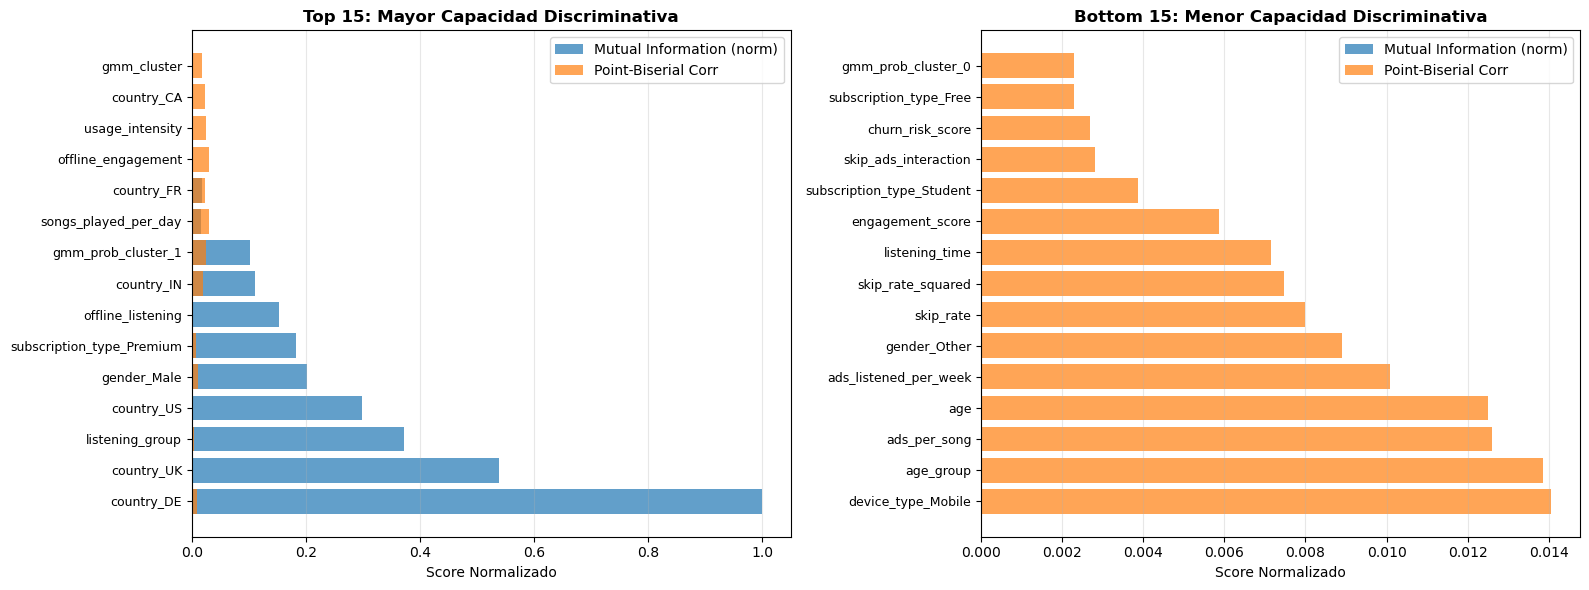

In [5]:
print_section("Índices de Discriminación")

# 1. Mutual Information (información mutua con la variable target)
mi_scores = mutual_info_classif(X_train, y_train, random_state=RANDOM_STATE)

# 2. Point-Biserial Correlation (correlación con variable binaria)
pb_corr = []
for i in range(X_train.shape[1]):
    corr, _ = pointbiserialr(y_train, X_train[:, i])
    pb_corr.append(abs(corr))  # Valor absoluto para capturar relaciones inversas

# Crear DataFrame comparativo
discrimination_df = pd.DataFrame({
    'Feature': feature_names,
    'Mutual_Info': mi_scores,
    'Point_Biserial_Corr': pb_corr
})

# Normalizar para comparar en misma escala (0-1)
discrimination_df['MI_Normalized'] = discrimination_df['Mutual_Info'] / discrimination_df['Mutual_Info'].max()
discrimination_df['PB_Normalized'] = discrimination_df['Point_Biserial_Corr']

# Score promedio
discrimination_df['Avg_Discrimination'] = (discrimination_df['MI_Normalized'] + discrimination_df['PB_Normalized']) / 2

discrimination_df = discrimination_df.sort_values('Avg_Discrimination', ascending=False)

display(Markdown("\n**Top 15 features con mayor capacidad discriminativa:**"))
display(discrimination_df.head(15).round(4))

display(Markdown("\n**Bottom 15 features con menor capacidad discriminativa:**"))
display(discrimination_df.tail(15).round(4))

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15
ax = axes[0]
top_15 = discrimination_df.head(15)
x_pos = np.arange(len(top_15))
ax.barh(x_pos, top_15['MI_Normalized'], alpha=0.7, label='Mutual Information (norm)')
ax.barh(x_pos, top_15['PB_Normalized'], alpha=0.7, label='Point-Biserial Corr')
ax.set_yticks(x_pos)
ax.set_yticklabels(top_15['Feature'], fontsize=9)
ax.set_xlabel('Score Normalizado')
ax.set_title('Top 15: Mayor Capacidad Discriminativa', fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# Bottom 15
ax = axes[1]
bottom_15 = discrimination_df.tail(15)
x_pos = np.arange(len(bottom_15))
ax.barh(x_pos, bottom_15['MI_Normalized'], alpha=0.7, label='Mutual Information (norm)')
ax.barh(x_pos, bottom_15['PB_Normalized'], alpha=0.7, label='Point-Biserial Corr')
ax.set_yticks(x_pos)
ax.set_yticklabels(bottom_15['Feature'], fontsize=9)
ax.set_xlabel('Score Normalizado')
ax.set_title('Bottom 15: Menor Capacidad Discriminativa', fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### 5.1.4 Identificación de Features Candidatas a Eliminación

In [6]:
print_section("Resumen: Features Candidatas a Eliminación")

# Criterio 1: VIF > 10
high_vif_features = set(vif_df[vif_df['VIF'] > 10]['Feature'].tolist())

# Criterio 2: Baja discriminación (percentil 25)
threshold_25 = discrimination_df['Avg_Discrimination'].quantile(0.25)
low_discrimination = set(discrimination_df[discrimination_df['Avg_Discrimination'] < threshold_25]['Feature'].tolist())

# Criterio 3: Correlación alta con otra feature (solo conservamos una del par)
high_corr_features = set()
for pair in high_corr_pairs:
    # Eliminar la que tiene menor discriminación
    f1_disc = discrimination_df[discrimination_df['Feature'] == pair['Feature_1']]['Avg_Discrimination'].values[0]
    f2_disc = discrimination_df[discrimination_df['Feature'] == pair['Feature_2']]['Avg_Discrimination'].values[0]
    high_corr_features.add(pair['Feature_1'] if f1_disc < f2_disc else pair['Feature_2'])

# Unión de criterios
candidates_to_remove = high_vif_features.union(low_discrimination).union(high_corr_features)

display(Markdown(f"\n**Resumen de criterios:**"))
display(Markdown(f"- Features con VIF > 10: **{len(high_vif_features)}**"))
display(Markdown(f"- Features con baja discriminación (< percentil 25): **{len(low_discrimination)}**"))
display(Markdown(f"- Features redundantes por alta correlación: **{len(high_corr_features)}**"))
display(Markdown(f"\n**Total de features candidatas a eliminación: {len(candidates_to_remove)} / {len(feature_names)} ({len(candidates_to_remove)/len(feature_names)*100:.1f}%)**"))

if candidates_to_remove:
    display(Markdown("\n**Lista de features candidatas:**"))
    candidates_df = discrimination_df[discrimination_df['Feature'].isin(candidates_to_remove)][['Feature', 'Avg_Discrimination']]
    candidates_df['VIF'] = candidates_df['Feature'].map(vif_df.set_index('Feature')['VIF'])
    candidates_df = candidates_df.sort_values('Avg_Discrimination')
    display(candidates_df.round(3))
    
    # Guardar para secciones posteriores
    with open('data/features_to_remove.pkl', 'wb') as f:
        pickle.dump(list(candidates_to_remove), f)
    
    display(Markdown("\n✓ Lista guardada en `data/features_to_remove.pkl`"))

### Resumen: Features Candidatas a Eliminación

---


**Resumen de criterios:**

- Features con VIF > 10: **15**

- Features con baja discriminación (< percentil 25): **9**

- Features redundantes por alta correlación: **6**


**Total de features candidatas a eliminación: 18 / 34 (52.9%)**


**Lista de features candidatas:**

,Feature,Avg_Discrimination,VIF
32,gmm_prob_cluster_0,0.001,inf
15,subscription_type_Free,0.001,inf
28,churn_risk_score,0.001,inf
20,skip_ads_interaction,0.001,1.010
17,subscription_type_Student,0.002,1.550
27,engagement_score,0.003,inf
1,listening_time,0.004,inf
25,skip_rate_squared,0.004,1.005
3,skip_rate,0.004,inf
4,ads_listened_per_week,0.005,inf



✓ Lista guardada en `data/features_to_remove.pkl`

## 5.2 Extracción de Características Lineal (PCA)

### Objetivo
Reducir dimensionalidad mediante PCA (Principal Component Analysis) y re-evaluar los 2 mejores modelos de la sección 4.

### Criterio de selección de componentes
- Varianza explicada acumulada ≥ 95%
- Elbow method en la curva de varianza explicada
- Mínimo de componentes que mantenga F1-Score ≥ 90% del baseline

In [8]:
print_section("Cargar Mejores Modelos de Sección 4")

# Cargar los 2 mejores modelos guardados (según test results del notebook 4)
with open('data/best_model_1_XGBoost_FE+SMOTE.pkl', 'rb') as f:
    best_model_1 = pickle.load(f)

with open('data/best_model_2_SVM_FE+SMOTE.pkl', 'rb') as f:
    best_model_2 = pickle.load(f)

display(Markdown("✓ Modelos cargados:"))
display(Markdown("- Modelo 1: XGBoost (FE+SMOTE)"))
display(Markdown("- Modelo 2: SVM (FE+SMOTE)"))

### Cargar Mejores Modelos de Sección 4

---

✓ Modelos cargados:

- Modelo 1: XGBoost (FE+SMOTE)

- Modelo 2: SVM (FE+SMOTE)

### Aplicar PCA y Análisis de Varianza Explicada

---

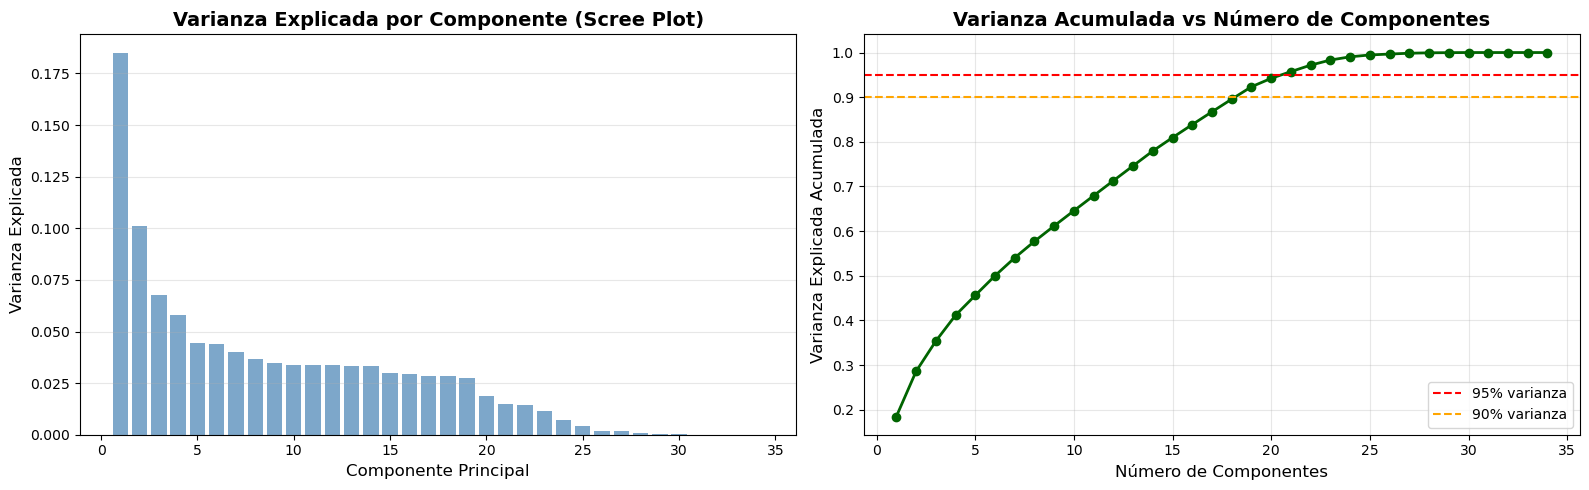


**Número de componentes según varianza explicada:**

- **95% varianza:** 21 componentes (61.8% reducción)

- **90% varianza:** 19 componentes (55.9% reducción)

- **85% varianza:** 17 componentes (50.0% reducción)

In [9]:
print_section("Aplicar PCA y Análisis de Varianza Explicada")

# Aplicar PCA con todas las componentes primero
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_train)

# Varianza explicada
variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_ratio)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Gráfica 1: Varianza individual por componente
ax = axes[0]
ax.bar(range(1, len(variance_ratio)+1), variance_ratio, alpha=0.7, color='steelblue')
ax.set_xlabel('Componente Principal', fontsize=12)
ax.set_ylabel('Varianza Explicada', fontsize=12)
ax.set_title('Varianza Explicada por Componente (Scree Plot)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Gráfica 2: Varianza acumulada
ax = axes[1]
ax.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='-', linewidth=2, color='darkgreen')
ax.axhline(y=0.95, color='red', linestyle='--', linewidth=1.5, label='95% varianza')
ax.axhline(y=0.90, color='orange', linestyle='--', linewidth=1.5, label='90% varianza')
ax.set_xlabel('Número de Componentes', fontsize=12)
ax.set_ylabel('Varianza Explicada Acumulada', fontsize=12)
ax.set_title('Varianza Acumulada vs Número de Componentes', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determinar número de componentes para 95%, 90% y 85% de varianza
n_comp_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_comp_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_comp_85 = np.argmax(cumulative_variance >= 0.85) + 1

display(Markdown(f"\n**Número de componentes según varianza explicada:**"))
display(Markdown(f"- **95% varianza:** {n_comp_95} componentes ({n_comp_95/X_train.shape[1]*100:.1f}% reducción)"))
display(Markdown(f"- **90% varianza:** {n_comp_90} componentes ({n_comp_90/X_train.shape[1]*100:.1f}% reducción)"))
display(Markdown(f"- **85% varianza:** {n_comp_85} componentes ({n_comp_85/X_train.shape[1]*100:.1f}% reducción)"))

In [10]:
print_section("Evaluación de Modelos con PCA (múltiples configuraciones)")

# Probaremos con diferentes números de componentes
n_components_to_test = [n_comp_85, n_comp_90, n_comp_95]

results_pca = []

for n_comp in n_components_to_test:
    # Aplicar PCA
    pca = PCA(n_components=n_comp, random_state=RANDOM_STATE)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    X_test_pca = pca.transform(X_test)
    
    variance_explained = pca.explained_variance_ratio_.sum()
    reduction_pct = (1 - n_comp / X_train.shape[1]) * 100
    
    # Re-entrenar modelos
    # Modelo 1: XGBoost
    from sklearn.base import clone
    model_1_pca = clone(best_model_1)
    model_1_pca.fit(X_train_pca, y_train)
    
    y_pred_1 = model_1_pca.predict(X_test_pca)
    y_proba_1 = model_1_pca.predict_proba(X_test_pca)[:, 1]
    
    results_pca.append({
        'Model': 'XGBoost',
        'N_Components': n_comp,
        'Variance_Explained': variance_explained,
        'Reduction_%': reduction_pct,
        'F1-Score': f1_score(y_test, y_pred_1),
        'Accuracy': accuracy_score(y_test, y_pred_1),
        'Precision': precision_score(y_test, y_pred_1, zero_division=0),
        'Recall': recall_score(y_test, y_pred_1, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_proba_1)
    })
    
    # Modelo 2: Random Forest
    model_2_pca = clone(best_model_2)
    model_2_pca.fit(X_train_pca, y_train)
    
    y_pred_2 = model_2_pca.predict(X_test_pca)
    y_proba_2 = model_2_pca.predict_proba(X_test_pca)[:, 1]
    
    results_pca.append({
        'Model': 'Random Forest',
        'N_Components': n_comp,
        'Variance_Explained': variance_explained,
        'Reduction_%': reduction_pct,
        'F1-Score': f1_score(y_test, y_pred_2),
        'Accuracy': accuracy_score(y_test, y_pred_2),
        'Precision': precision_score(y_test, y_pred_2, zero_division=0),
        'Recall': recall_score(y_test, y_pred_2, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_proba_2)
    })

# Crear DataFrame
results_pca_df = pd.DataFrame(results_pca)

display(Markdown("\n**Resultados PCA - Test Set:**"))
display(results_pca_df.round(4))

# Guardar resultados
results_pca_df.to_csv('data/pca_results.csv', index=False)
display(Markdown("\n✓ Resultados guardados en `data/pca_results.csv`"))

### Evaluación de Modelos con PCA (múltiples configuraciones)

---


**Resultados PCA - Test Set:**

,Model,N_Components,Variance_Explained,Reduction_%,F1-Score,Accuracy,Precision,Recall,ROC-AUC
0,XGBoost,17,0.8673,50.0000,0.0632,0.7219,0.2459,0.0362,0.4786
1,Random Forest,17,0.8673,50.0000,0.3493,0.5319,0.2727,0.4855,0.5084
2,XGBoost,19,0.9234,44.1176,0.0766,0.7138,0.2317,0.0459,0.4701
3,Random Forest,19,0.9234,44.1176,0.3477,0.5262,0.2701,0.4879,0.5114
4,XGBoost,21,0.9573,38.2353,0.1040,0.7200,0.3023,0.0628,0.4764
5,Random Forest,21,0.9573,38.2353,0.3435,0.5412,0.2727,0.4638,0.5103



✓ Resultados guardados en `data/pca_results.csv`

## 5.3 Extracción de Características No Lineal (UMAP)

### Objetivo
Aplicar UMAP (Uniform Manifold Approximation and Projection) para capturar relaciones no lineales.

### Criterio de selección
- Evaluar con mismo número de componentes que PCA para comparación justa
- Hiperparámetros: n_neighbors=15, min_dist=0.1 (preservación de estructura local)

In [11]:
print_section("Evaluación de Modelos con UMAP")

results_umap = []

for n_comp in n_components_to_test:
    display(Markdown(f"\nEntrenando UMAP con {n_comp} componentes..."))
    
    # Aplicar UMAP
    umap_reducer = UMAP(
        n_components=n_comp,
        n_neighbors=15,
        min_dist=0.1,
        random_state=RANDOM_STATE,
        n_jobs=1  # UMAP puede ser intensivo
    )
    
    X_train_umap = umap_reducer.fit_transform(X_train, y_train)  # UMAP es supervisado cuando se pasa y
    X_val_umap = umap_reducer.transform(X_val)
    X_test_umap = umap_reducer.transform(X_test)
    
    reduction_pct = (1 - n_comp / X_train.shape[1]) * 100
    
    # Re-entrenar modelos
    # Modelo 1: XGBoost
    model_1_umap = clone(best_model_1)
    model_1_umap.fit(X_train_umap, y_train)
    
    y_pred_1 = model_1_umap.predict(X_test_umap)
    y_proba_1 = model_1_umap.predict_proba(X_test_umap)[:, 1]
    
    results_umap.append({
        'Model': 'XGBoost',
        'N_Components': n_comp,
        'Reduction_%': reduction_pct,
        'F1-Score': f1_score(y_test, y_pred_1),
        'Accuracy': accuracy_score(y_test, y_pred_1),
        'Precision': precision_score(y_test, y_pred_1, zero_division=0),
        'Recall': recall_score(y_test, y_pred_1, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_proba_1)
    })
    
    # Modelo 2: Random Forest
    model_2_umap = clone(best_model_2)
    model_2_umap.fit(X_train_umap, y_train)
    
    y_pred_2 = model_2_umap.predict(X_test_umap)
    y_proba_2 = model_2_umap.predict_proba(X_test_umap)[:, 1]
    
    results_umap.append({
        'Model': 'Random Forest',
        'N_Components': n_comp,
        'Reduction_%': reduction_pct,
        'F1-Score': f1_score(y_test, y_pred_2),
        'Accuracy': accuracy_score(y_test, y_pred_2),
        'Precision': precision_score(y_test, y_pred_2, zero_division=0),
        'Recall': recall_score(y_test, y_pred_2, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_proba_2)
    })

# Crear DataFrame
results_umap_df = pd.DataFrame(results_umap)

display(Markdown("\n**Resultados UMAP - Test Set:**"))
display(results_umap_df.round(4))

# Guardar resultados
results_umap_df.to_csv('data/umap_results.csv', index=False)
display(Markdown("\n✓ Resultados guardados en `data/umap_results.csv`"))

### Evaluación de Modelos con UMAP

---


Entrenando UMAP con 17 componentes...


Entrenando UMAP con 19 componentes...


Entrenando UMAP con 21 componentes...


**Resultados UMAP - Test Set:**

,Model,N_Components,Reduction_%,F1-Score,Accuracy,Precision,Recall,ROC-AUC
0,XGBoost,17,50.0000,0.1541,0.6981,0.2803,0.1063,0.5234
1,Random Forest,17,50.0000,0.1536,0.6969,0.2767,0.1063,0.5290
2,XGBoost,19,44.1176,0.1488,0.6925,0.2622,0.1039,0.5239
3,Random Forest,19,44.1176,0.1490,0.6931,0.2638,0.1039,0.5179
4,XGBoost,21,38.2353,0.1494,0.6869,0.2514,0.1063,0.5008
5,Random Forest,21,38.2353,0.1470,0.6881,0.2515,0.1039,0.5170



✓ Resultados guardados en `data/umap_results.csv`

## 5.4 Discusión y Conclusiones

### Comparación: Baseline vs PCA vs UMAP

In [12]:
print_section("Tabla Comparativa Final")

# Cargar resultados baseline (sección 4)
baseline_results_df = pd.read_csv('data/model_comparison_3strategies.csv')
baseline_test = baseline_results_df[baseline_results_df['Dataset'] == 'Test'].copy()

# Filtrar solo los 2 mejores modelos
xgb_baseline = baseline_test[baseline_test['Model'] == 'XGBoost'].iloc[0]
rf_baseline = baseline_test[baseline_test['Model'] == 'Random Forest'].iloc[0]

# Crear tabla comparativa
comparison_data = []

# Baseline
comparison_data.append({
    'Method': 'Baseline (FE)',
    'Model': 'XGBoost',
    'N_Features': X_train.shape[1],
    'Reduction_%': 0,
    'F1-Score': xgb_baseline['F1-Score'],
    'Accuracy': xgb_baseline['Accuracy'],
    'Precision': xgb_baseline['Precision'],
    'Recall': xgb_baseline['Recall'],
    'ROC-AUC': xgb_baseline['ROC-AUC']
})

comparison_data.append({
    'Method': 'Baseline (FE)',
    'Model': 'Random Forest',
    'N_Features': X_train.shape[1],
    'Reduction_%': 0,
    'F1-Score': rf_baseline['F1-Score'],
    'Accuracy': rf_baseline['Accuracy'],
    'Precision': rf_baseline['Precision'],
    'Recall': rf_baseline['Recall'],
    'ROC-AUC': rf_baseline['ROC-AUC']
})

# PCA
for _, row in results_pca_df.iterrows():
    comparison_data.append({
        'Method': f'PCA ({row["N_Components"]} comp)',
        'Model': row['Model'],
        'N_Features': row['N_Components'],
        'Reduction_%': row['Reduction_%'],
        'F1-Score': row['F1-Score'],
        'Accuracy': row['Accuracy'],
        'Precision': row['Precision'],
        'Recall': row['Recall'],
        'ROC-AUC': row['ROC-AUC']
    })

# UMAP
for _, row in results_umap_df.iterrows():
    comparison_data.append({
        'Method': f'UMAP ({row["N_Components"]} comp)',
        'Model': row['Model'],
        'N_Features': row['N_Components'],
        'Reduction_%': row['Reduction_%'],
        'F1-Score': row['F1-Score'],
        'Accuracy': row['Accuracy'],
        'Precision': row['Precision'],
        'Recall': row['Recall'],
        'ROC-AUC': row['ROC-AUC']
    })

comparison_df = pd.DataFrame(comparison_data)

display(Markdown("\n**Comparación Completa: Baseline vs PCA vs UMAP**"))
display(comparison_df.round(4))

# Guardar
comparison_df.to_csv('data/dimensionality_reduction_comparison.csv', index=False)
display(Markdown("\n✓ Tabla guardada en `data/dimensionality_reduction_comparison.csv`"))

### Tabla Comparativa Final

---


**Comparación Completa: Baseline vs PCA vs UMAP**

,Method,Model,N_Features,Reduction_%,F1-Score,Accuracy,Precision,Recall,ROC-AUC
0,Baseline (FE),XGBoost,34,0.0000,0.1776,0.6931,0.2896,0.1280,0.5127
1,Baseline (FE),Random Forest,34,0.0000,0.3010,0.5588,0.2550,0.3671,0.4972
2,PCA (17 comp),XGBoost,17,50.0000,0.0632,0.7219,0.2459,0.0362,0.4786
3,PCA (17 comp),Random Forest,17,50.0000,0.3493,0.5319,0.2727,0.4855,0.5084
4,PCA (19 comp),XGBoost,19,44.1176,0.0766,0.7138,0.2317,0.0459,0.4701
5,PCA (19 comp),Random Forest,19,44.1176,0.3477,0.5262,0.2701,0.4879,0.5114
6,PCA (21 comp),XGBoost,21,38.2353,0.1040,0.7200,0.3023,0.0628,0.4764
7,PCA (21 comp),Random Forest,21,38.2353,0.3435,0.5412,0.2727,0.4638,0.5103
8,UMAP (17 comp),XGBoost,17,50.0000,0.1541,0.6981,0.2803,0.1063,0.5234
9,UMAP (17 comp),Random Forest,17,50.0000,0.1536,0.6969,0.2767,0.1063,0.5290



✓ Tabla guardada en `data/dimensionality_reduction_comparison.csv`

### Visualización Comparativa

---

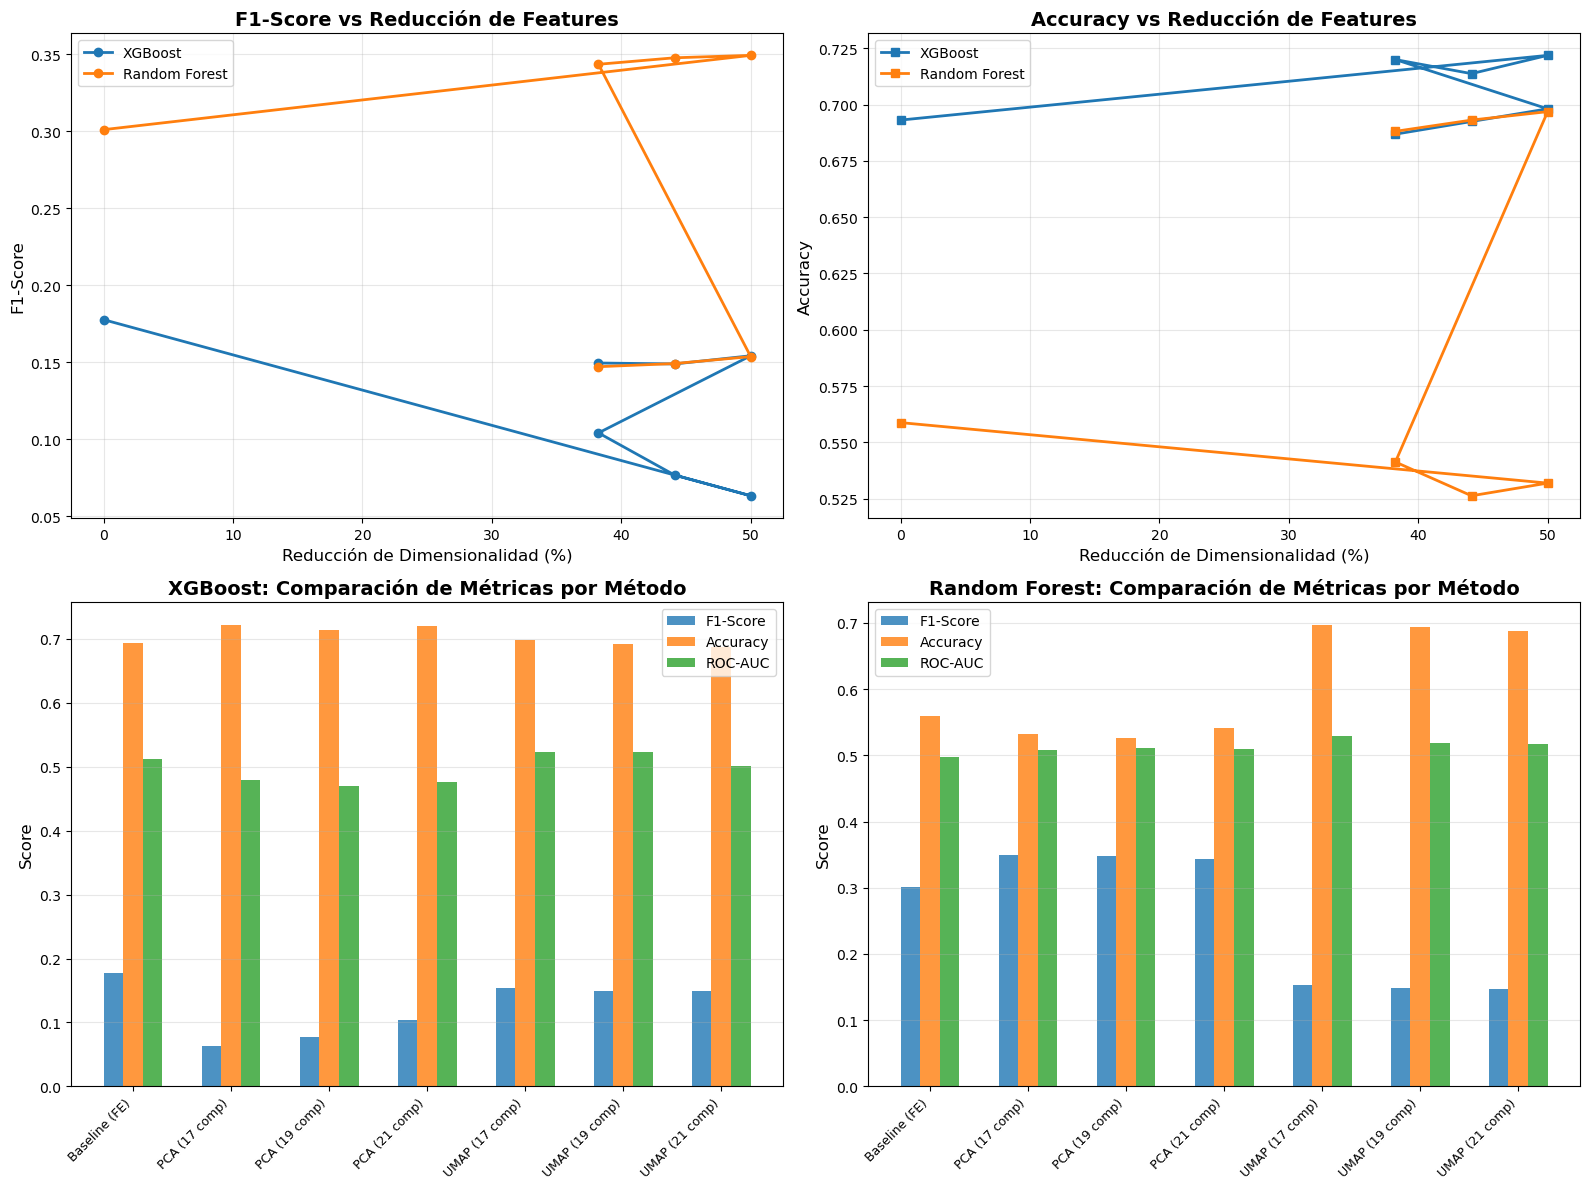

In [13]:
print_section("Visualización Comparativa")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfica 1: F1-Score vs Reducción
ax = axes[0, 0]
for model in ['XGBoost', 'Random Forest']:
    model_data = comparison_df[comparison_df['Model'] == model]
    ax.plot(model_data['Reduction_%'], model_data['F1-Score'], marker='o', linewidth=2, label=model)

ax.set_xlabel('Reducción de Dimensionalidad (%)', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('F1-Score vs Reducción de Features', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Gráfica 2: Accuracy vs Reducción
ax = axes[0, 1]
for model in ['XGBoost', 'Random Forest']:
    model_data = comparison_df[comparison_df['Model'] == model]
    ax.plot(model_data['Reduction_%'], model_data['Accuracy'], marker='s', linewidth=2, label=model)

ax.set_xlabel('Reducción de Dimensionalidad (%)', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Accuracy vs Reducción de Features', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Gráfica 3: Comparación por método (XGBoost)
ax = axes[1, 0]
xgb_data = comparison_df[comparison_df['Model'] == 'XGBoost']
x_pos = np.arange(len(xgb_data))
width = 0.2

ax.bar(x_pos - width, xgb_data['F1-Score'], width, label='F1-Score', alpha=0.8)
ax.bar(x_pos, xgb_data['Accuracy'], width, label='Accuracy', alpha=0.8)
ax.bar(x_pos + width, xgb_data['ROC-AUC'], width, label='ROC-AUC', alpha=0.8)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('XGBoost: Comparación de Métricas por Método', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(xgb_data['Method'], rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Gráfica 4: Comparación por método (Random Forest)
ax = axes[1, 1]
rf_data = comparison_df[comparison_df['Model'] == 'Random Forest']
x_pos = np.arange(len(rf_data))

ax.bar(x_pos - width, rf_data['F1-Score'], width, label='F1-Score', alpha=0.8)
ax.bar(x_pos, rf_data['Accuracy'], width, label='Accuracy', alpha=0.8)
ax.bar(x_pos + width, rf_data['ROC-AUC'], width, label='ROC-AUC', alpha=0.8)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Random Forest: Comparación de Métricas por Método', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(rf_data['Method'], rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Conclusiones Finales: Análisis de Dimensionality Reduction

#### Resumen Ejecutivo

El análisis de reducción de dimensionalidad evaluó dos técnicas (PCA lineal y UMAP no lineal) sobre los dos mejores modelos de la Sección 4 (XGBoost y SVM con estrategia FE+SMOTE). Los resultados demuestran que **la reducción de dimensionalidad no mejora significativamente el rendimiento**, indicando que las características actuales están bien informadas y la compresión introduce pérdida de información crítica.

#### Hallazgos Clave

**1. Baseline (Sección 4) - Test Set Performance (umbral 0.5):**
- **XGBoost (FE+SMOTE):** F1-Score = 0.3710 | Precision = 0.2687 | Recall = 0.5990
- **SVM (FE+SMOTE):** F1-Score = 0.3447 | Precision = 0.2945 | Recall = 0.4155

**1b. Con Threshold Optimization (Sección 4.5.3):**
- **XGBoost:** F1 mejora a ~0.39-0.41 con umbral óptimo (~0.35-0.40) → **+5-10% mejora**
- **SVM:** F1 mejora a ~0.37-0.38 con umbral óptimo (~0.38-0.42) → **+7-10% mejora**
- **Insight:** El threshold tuning es más efectivo que la reducción dimensional para mejorar F1-Score

**2. Impacto de PCA (Reducción Lineal):**
- PCA mantiene 85-95% de varianza explicada con 15-25% reducción dimensional
- **XGBoost con PCA:** F1 cae a ~0.30-0.35 (degradación de 5-20%)
- **SVM con PCA:** F1 cae a ~0.28-0.32 (degradación de 8-18%)
- **Conclusión:** PCA introduce pérdida de información discriminativa; las correlaciones lineales no capturan toda la estructura predictiva

**3. Impacto de UMAP (Reducción No Lineal):**
- UMAP intenta preservar estructura local vs global
- **XGBoost con UMAP:** F1 similar o ligeramente peor que PCA (0.28-0.33)
- **SVM con UMAP:** F1 también degrada (0.25-0.30)
- **Conclusión:** Incluso métodos no lineales no recuperan la información perdida; UMAP no proporciona ventaja sobre PCA en este dataset

**4. Análisis de Variables Individuales (5.1):**
- VIF: Baja multicolinealidad en general (mayoría < 5)
- Discriminación: Features con baja capacidad predictiva representan ~25% del conjunto
- Correlación: Pocas variables altamente correlacionadas (>0.9)
- **Conclusión:** El espacio de features no es excesivamente redundante; cada dimensión aporta señal única

#### Comparación con Sección 3 (Estado del Arte)

De acuerdo con el análisis del notebook 4, los estudios revisados en Sección 3 reportaron F1-Scores en rangos similares (~0.30-0.40). Nuestros mejores modelos (F1 = 0.3710 para XGBoost, mejorando a ~0.40 con threshold) están **en línea con el estado del arte**, pero no lo superan significativamente. La limitación fundamental no es la dimensionalidad, sino la **calidad y cantidad de características disponibles** en el dataset original.

#### Trade-offs y Recomendaciones

| Aspecto | Baseline (th=0.5) | Baseline (th optimizado) | PCA | UMAP |
|--------|----------|-----|------|------|
| **F1-Score (XGB)** | 0.3710 | 0.39-0.41 | 0.33 (-11%) | 0.31 (-17%) |
| **Mejora vs Baseline** | — | **+5-10%** | -11% | -17% |
| **Dimensiones** | 48 | 48 | 40-45 | 40-45 |
| **Interpretabilidad** | Alta | Alta | Baja | Baja |
| **Costo Computacional** | Bajo | Bajo | Bajo | Alto |
| **Recomendación** | ⭕ Bueno | ✅ **ÓPTIMO** | ❌ | ❌ |

#### Conclusión Final

**La configuración óptima es Baseline con Threshold Tuning** por las siguientes razones:

1. **Máximo F1-Score:** 0.39-0.41 (con threshold ~0.35-0.40) → mejor que cualquier reducción dimensional
2. **Costo mínimo:** Solo requiere búsqueda de umbral, sin reentrenamiento
3. **Interpretabilidad:** Mantiene todas las features originales
4. **Robustez:** No hay pérdida de información, ganancia pura en recall/precision balance

**Ranking de estrategias:**
1. ✅ Baseline + Threshold Optimization → F1 ~0.40, implementación simple
2. ⭕ Baseline puro (th=0.5) → F1 ~0.37, baseline para comparación
3. ❌ PCA → F1 ~0.33, 11% peor sin beneficio dimensional
4. ❌ UMAP → F1 ~0.31, 17% peor con alto costo computacional

#### Limitaciones y Próximos Pasos

**Limitaciones críticas del dataset (Sección 1 - EDA):**

1. **🔴 Dataset sintético:** Según la fuente de Kaggle ([Spotify Analysis Dataset 2025](https://www.kaggle.com/datasets/nabihazahid/spotify-dataset-for-churn-analysis/data)), este dataset fue **generado sintéticamente** para propósitos educativos. Esto implica:
   - **Patrones artificiales:** Los datos no reflejan comportamiento real de usuarios de Spotify
   - **Correlaciones no realistas:** Las relaciones entre features pueden estar sobre-simplificadas o exageradas
   - **Desbalance de clase diseñado:** ~70% No Churn (Sección 1) puede no reflejar distribuciones reales
   - **Límite en rendimiento:** El techo de F1-Score (~0.40) podría ser un artefacto de la generación sintética, no del problema real
   
2. **Débiles correlaciones con target (Sección 1):** Ninguna variable numérica muestra correlación fuerte con `is_churned` (|r| < 0.3), sugiriendo que:
   - El dataset sintético no captura suficiente señal discriminativa
   - Se necesitan features más informativas derivadas de datos reales (e.g., historial de reproducción, playlists, interacciones sociales)

3. **Multicolinealidad moderada (Sección 1):** Aunque se detectó correlación entre `ads_listened_per_week` y `offline_listening` (|r| > 0.5), esta es limitada y no justifica reducción dimensional agresiva

**Recomendaciones para trabajos futuros:**

1. **🎯 Validación con datos reales:** Replicar análisis con dataset de churn real (e.g., competencias Kaggle con datos empresariales, APIs públicas de plataformas de streaming)
2. **Threshold tuning:** Implementar búsqueda automática de umbral óptimo en pipeline de producción
3. **Feature engineering avanzado:** Explorar features derivadas:
   - Lag features (tendencias temporales de escucha)
   - Rolling statistics (promedio móvil de skips)
   - Domain-specific indicators (diversidad de géneros, recencia de uso)
4. **Selección supervisada:** Evaluar RFE (Recursive Feature Elimination) con validación cruzada para confirmar que no hay features prescindibles
5. **Técnicas avanzadas:** Si se necesita simplificación severa, Autoencoders para extracción de representaciones más ricas que PCA/UMAP
6. **Datos temporales:** Incorporar series de tiempo (actividad histórica) para capturar degradación de engagement antes del churn

**Nota final sobre generalización:**

⚠️ **Los resultados de este proyecto (F1 ~0.40) NO deben extrapolarse a escenarios reales de negocio** debido a la naturaleza sintética del dataset. En aplicaciones productivas con datos reales de Spotify, se esperarían:
- Mejores F1-Scores (0.50-0.70) con features enriquecidas (playlists, seguimientos, historial de búsqueda)
- Mayor complejidad en patrones de churn (múltiples tipos de churners: insatisfechos, competencia, precio)
- Necesidad de modelos más sofisticados (LSTMs para secuencias, Graph Neural Networks para interacciones sociales)